In [1]:
import sys
from datetime import date
from io import BytesIO
from IPython import display

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

import base64
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import uuid

# parent directory to work with dev
sys.path.append("..")
import model_card_toolkit as mctlib

In [2]:
cancer = load_breast_cancer()

X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [3]:
# Utility function that will export a plot to a base-64 encoded string that the model card will accept.

def plot_to_str():
    img = BytesIO()
    plt.savefig(img, format='png', bbox_inches="tight")
    return base64.encodebytes(img.getvalue()).decode('utf-8')

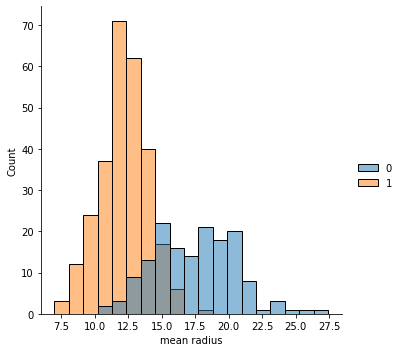

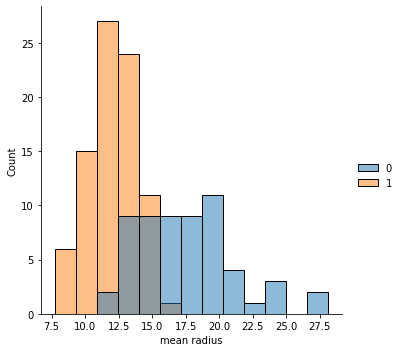

In [4]:
# Plot the mean radius feature for both the train and test sets

sns.displot(x=X_train['mean radius'], hue=y_train)
mean_radius_train = plot_to_str()

sns.displot(x=X_test['mean radius'], hue=y_test)
mean_radius_test = plot_to_str()

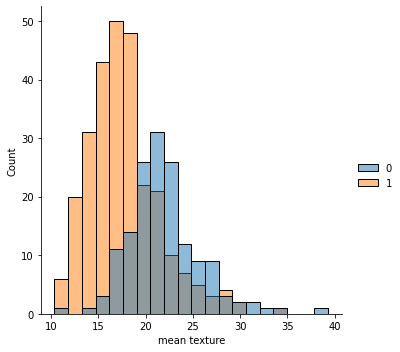

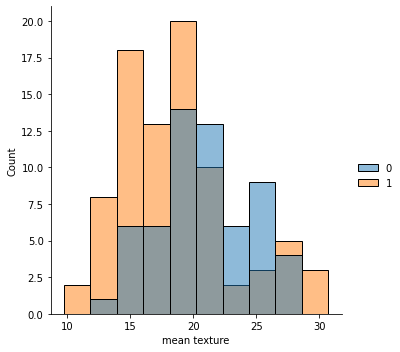

In [5]:
# Plot the mean texture feature for both the train and test sets

sns.displot(x=X_train['mean texture'], hue=y_train)
mean_texture_train = plot_to_str()

sns.displot(x=X_test['mean texture'], hue=y_test)
mean_texture_test = plot_to_str()

In [6]:
# Create a classifier and fit the training data

clf = GradientBoostingClassifier().fit(X_train, y_train)

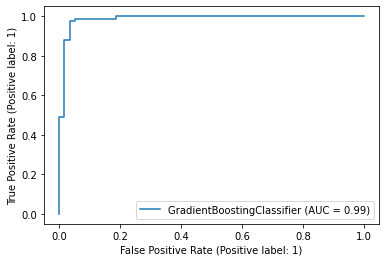

In [7]:
# Plot a ROC curve

plot_roc_curve(clf, X_test, y_test)
roc_curve = plot_to_str()

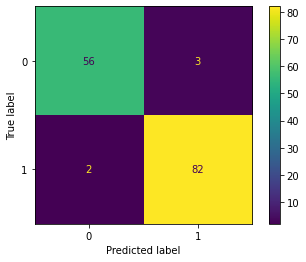

In [8]:
# Plot a confusion matrix

plot_confusion_matrix(clf, X_test, y_test)
confusion_matrix = plot_to_str()

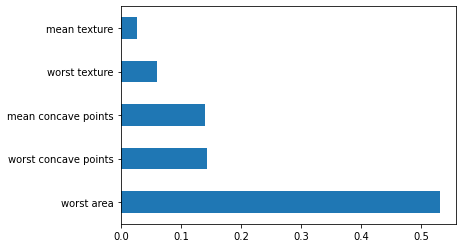

In [9]:
feature_importances = pd.Series(clf.feature_importances_, index=cancer.feature_names)
feature_importances.sort_values(ascending=False).head().plot.barh()
top5_features = plot_to_str()

In [10]:
mc = mctlib.ModelCard()
mct = mctlib.ModelCardToolkit(output_dir="model_card_output", file_name="breast_cancer_diagnostic_model_card")
model_card = mct.scaffold_assets()

In [11]:
model_card.model_details.name = 'Breast Cancer Wisconsin (Diagnostic) Dataset'
model_card.model_details.overview = (
    'This model predicts whether breast cancer is benign or malignant based on '
    'image measurements.')
model_card.model_details.owners = [
    mctlib.Owner(name= 'Model Cards Team', contact='model-cards@google.com', role="auditor")
]
model_card.model_details.references = [
    mctlib.Reference(reference='https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)'),
    mctlib.Reference(reference='https://minds.wisconsin.edu/bitstream/handle/1793/59692/TR1131.pdf')
]
model_card.model_details.version.name = str(uuid.uuid4())
model_card.model_details.version.date = str(date.today())

model_card.considerations.ethical_considerations = [mctlib.Risk(
    name=('Manual selection of image sections to digitize could create '
            'selection bias'),
    mitigation_strategy='Automate the selection process'
)]
model_card.considerations.limitations = [mctlib.Limitation(description='Breast cancer diagnosis')]
model_card.considerations.use_cases = [mctlib.UseCase(description='Breast cancer diagnosis')]
model_card.considerations.users = [mctlib.User(description='Medical professionals'), mctlib.User(description='ML researchers')]

model_card.model_parameters.data.append(mctlib.Dataset())
model_card.model_parameters.data[0].graphics.description = (
  f'{len(X_train)} rows with {len(X_train.columns)} features')
model_card.model_parameters.data[0].graphics.collection = [
    mctlib.Graphic(image=mean_radius_train),
    mctlib.Graphic(image=mean_texture_train)
]
model_card.model_parameters.data.append(mctlib.Dataset())
model_card.model_parameters.data[1].graphics.description = (
  f'{len(X_test)} rows with {len(X_test.columns)} features')
model_card.model_parameters.data[1].graphics.collection = [
    mctlib.Graphic(image=mean_radius_test),
    mctlib.Graphic(image=mean_texture_test)
]

model_card.quantitative_analysis.performance_metrics.append(mctlib.PerformanceMetric())
model_card.quantitative_analysis.performance_metrics[0].type = "accuracy"
model_card.quantitative_analysis.performance_metrics[0].value = str((49 + 89) / (49 + 89 + 2 + 3))
model_card.quantitative_analysis.performance_metrics[0].slice = "training"
model_card.quantitative_analysis.performance_metrics[0].graphics.description = (
  'ROC curve and confusion matrix')
model_card.quantitative_analysis.performance_metrics[0].graphics.collection = [
    mctlib.Graphic(image=roc_curve),
    mctlib.Graphic(image=confusion_matrix)
]

model_card.explainability_analysis.explainability_reports = [
    mctlib.ExplainabilityReport(
        type="Feature Importance",
        slice="training",
        description="top 5 features",
        graphics = mctlib.GraphicsCollection(collection = [
          mctlib.Graphic(image=top5_features)  
        ]),
    )
]

model_card.fairness_analysis.fairness_reports = [
    mctlib.FairnessReport(
        type="fairness parity metric",
        slice="training",
        segment="gender",
        description="TPR",
        tests= [
            mctlib.Test(name="sample test 1", description="feature explainability test", threshold=str(0.6), result=str(0.7), passed=False),
            mctlib.Test(name="sample test 2", description="feature explainability test 2", threshold=str(0.6), result=str(0.7), passed=True),
            mctlib.Test(name="sample test 3", description="feature explainability test 3", threshold=str(0.6), result=str(0.7), passed=False)
        ]
    )
]

mct.update_model_card(model_card)

In [55]:
md = mct.export_format(output_file="breast_cancer_diagnostic_model_card.md", template_path="model_card_output/template/md/default_template.md.jinja")

In [50]:
html = mct.export_format(output_file="breast_cancer_diagnostic_model_card.html")

display.display(display.HTML(html))